<a href="https://colab.research.google.com/github/omkarwazulkar/ImbalancedClassificationProjects/blob/main/Oil_Spill_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pandas import read_csv

path = '/content/drive/MyDrive/Dataset/Datasets/oil-spill.csv'
dataframe = read_csv(path, header=None)
print(dataframe.shape)

(937, 50)


In [ ]:
# Summarize 
from collections import Counter

target = dataframe.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
  per = v / len(target) * 100
  print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=1, Count=41, Percentage=4.376%
Class=0, Count=896, Percentage=95.624%


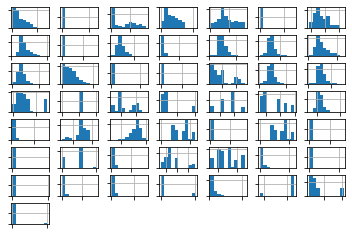

In [ ]:
from matplotlib import pyplot

ax = dataframe.hist()
for axis in ax.flatten():
  axis.set_title('')
  axis.set_xticklabels([])
  axis.set_yticklabels([])
pyplot.show()

In [ ]:
report = dataframe.describe()
print(report)

               0             1   ...          48          49
count  937.000000    937.000000  ...  937.000000  937.000000
mean    81.588047    332.842049  ...    8.119723    0.043757
std     64.976730   1931.938570  ...    2.908895    0.204662
min      1.000000     10.000000  ...    5.810000    0.000000
25%     31.000000     20.000000  ...    6.340000    0.000000
50%     64.000000     65.000000  ...    7.220000    0.000000
75%    124.000000    132.000000  ...    7.840000    0.000000
max    352.000000  32389.000000  ...   15.440000    1.000000

[8 rows x 50 columns]


In [ ]:
path = '/content/drive/MyDrive/Dataset/Datasets/oil-spill.csv'

In [ ]:
# Load Dataset Function
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder

def load_dataset(full_path):
  data = read_csv(full_path, header=None)
  data.drop(22, axis=1, inplace=True)
  data.drop(0, axis=1, inplace=True)
  data = data.values
  X, y = data[:, :-1], data[:, -1]
  y = LabelEncoder().fit_transform(y)
  return X, y

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer
from imblearn.metrics import geometric_mean_score

def evaluate_model(X, y, model):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  metric = make_scorer(geometric_mean_score)
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

In [ ]:
from numpy import std
from numpy import mean
from sklearn.dummy import DummyClassifier

X, y = load_dataset(path)
print(X.shape, y.shape, Counter(y))
model = DummyClassifier(strategy='uniform')
scores = evaluate_model(X, y, model)
print('Mean G-Mean: %.3f (%.3f)' % (mean(scores), std(scores)))

(937, 47) (937,) Counter({0: 896, 1: 41})
Mean G-Mean: 0.482 (0.152)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def get_models():
  models, names = list(), list()
  # LR
  steps = [('t',StandardScaler()),('m',LogisticRegression(solver='liblinear'))]
  models.append(Pipeline(steps=steps))
  names.append('LR')
  # LDA
  steps = [('t', StandardScaler()),('m',LinearDiscriminantAnalysis())]
  models.append(Pipeline(steps=steps))
  names.append('LDA')
  # NB
  models.append(GaussianNB())
  names.append('NB')
  return models, names

In [ ]:
models, names = get_models()
results = list()
for i in range(len(models)):
  scores = evaluate_model(X, y, models[i])
  results.append(scores)
  print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))

>LR 0.672 (0.203)
>LDA 0.755 (0.147)
>NB 0.707 (0.202)


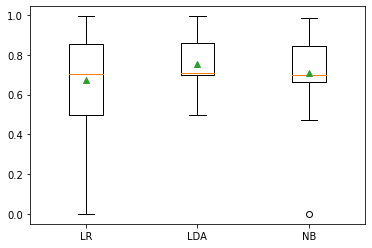

In [ ]:
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

def get_models():
  models, names = list(), list()
  # LR Balanced
  models.append(LogisticRegression(solver='liblinear', class_weight='balanced'))
  names.append('Balanced')
  # LR Balanced + Normalization
  steps = [('t',MinMaxScaler()), ('m', LogisticRegression(solver='liblinear',
  class_weight='balanced'))]
  models.append(Pipeline(steps=steps))
  names.append('Balanced-Norm')
  # LR Balanced + Standardization
  steps = [('t',StandardScaler()), ('m', LogisticRegression(solver='liblinear',
  class_weight='balanced'))]
  models.append(Pipeline(steps=steps))
  names.append('Balanced-Std')
  # LR Balanced + Power
  steps = [('t1',MinMaxScaler()), ('t2',PowerTransformer()), ('m',
  LogisticRegression(solver='liblinear', class_weight='balanced'))]
  models.append(Pipeline(steps=steps))
  names.append('Balanced-Power')
  return models, names

>Balanced 0.848 (0.115)
>Balanced-Norm 0.836 (0.088)
>Balanced-Std 0.834 (0.129)
>Balanced-Power 0.862 (0.124)


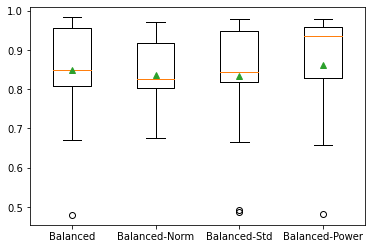

In [ ]:
models, names = get_models()
results = list()
for i in range(len(models)):
  scores = evaluate_model(X, y, models[i])
  results.append(scores)
  print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline

def get_models():
  models, names = list(), list()
  # SMOTEENN
  sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
  model = LogisticRegression(solver='liblinear')
  steps = [('e', sampling), ('m', model)]
  models.append(Pipeline(steps=steps))
  names.append('LR')
  # SMOTEENN + Norm
  sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
  model = LogisticRegression(solver='liblinear')
  steps = [('t', MinMaxScaler()), ('e', sampling), ('m', model)]
  models.append(Pipeline(steps=steps))
  names.append('Norm')
  # SMOTEENN + Std
  sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
  model = LogisticRegression(solver='liblinear')
  steps = [('t', StandardScaler()), ('e', sampling), ('m', model)]
  models.append(Pipeline(steps=steps))
  names.append('Std')
  # SMOTEENN + Power
  sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
  model = LogisticRegression(solver='liblinear')
  steps = [('t1', MinMaxScaler()), ('t2', PowerTransformer()), ('e', sampling), ('m',
  model)]
  models.append(Pipeline(steps=steps))
  names.append('Power')
  return models, names

>LR 0.859 (0.101)
>Norm 0.837 (0.094)
>Std 0.816 (0.147)
>Power 0.877 (0.121)


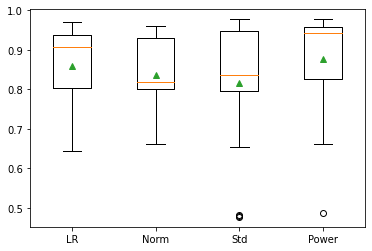

In [ ]:
models, names = get_models()
results = list()
for i in range(len(models)):
  scores = evaluate_model(X, y, models[i])
  print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
  results.append(scores)
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
# Finalizing the Model

smoteenn = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
model = LogisticRegression(solver='liblinear')
pipeline = Pipeline(steps=[('e', smoteenn), ('m', model)])
pipeline.fit(X, y)

Pipeline(steps=[('e',
                 SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))),
                ('m', LogisticRegression(solver='liblinear'))])

In [ ]:
print('Non-Spill Cases:')
data = [[329, 1627.54, 1409.43, 51, 822500, 35, 6.1, 4610, 0.17, 178.4, 0.2, 0.24, 0.39,
         0.12, 0.27, 138.32, 34.81, 2.02, 0.14, 0.19, 75.26, 0, 0.47, 351.67, 0.18, 9.24, 0.38,
         2.57, -2.96, -0.28, 1.93, 0, 1.93, 34, 1710, 0, 25.84, 78, 55, 1460.31, 710.63, 451.78,
         150.85, 3.23, 0, 4530.75, 66.25],
        [3234, 1091.56, 1357.96, 32, 8085000, 40.08, 8.98, 25450, 0.22, 317.7, 0.18, 0.2, 0.49,
         0.09, 0.41, 114.69, 41.87, 2.31, 0.15, 0.18, 75.26, 0, 0.53, 351.67, 0.18, 9.24,
         0.24, 3.56, -3.09, -0.31, 2.17, 0, 2.17, 281, 14490, 0, 80.11, 78, 55, 4287.77,
         3095.56, 1937.42, 773.69, 2.21, 0, 4927.51, 66.15],
        [2339, 1537.68, 1633.02, 45, 5847500, 38.13, 9.29, 22110, 0.24, 264.5, 0.21, 0.26, 0.79,
         0.08, 0.71, 89.49, 32.23, 2.2, 0.17, 0.22, 75.26, 0, 0.51, 351.67, 0.18, 9.24, 0.27,
         4.21, -2.84, -0.29, 2.16, 0, 2.16, 228, 12150, 0, 83.6, 78, 55, 3959.8, 2404.16,
         1530.38, 659.67, 2.59, 0, 4732.04, 66.34]]
for row in data:
  yhat = pipeline.predict([row])
  label = yhat[0]
  print('>Predicted=%d (expected 0)' % (label))

Non-Spill Cases:
>Predicted=0 (expected 0)
>Predicted=1 (expected 0)
>Predicted=1 (expected 0)


In [ ]:
print('Spill Cases:')
data = [[2971, 1020.91, 630.8, 59, 7427500, 32.76, 10.48, 17380, 0.32, 427.4, 0.22, 0.29,
        0.5, 0.08, 0.42, 149.87, 50.99, 1.89, 0.14, 0.18, 75.26, 0, 0.44, 351.67, 0.18, 9.24,
        2.5, 10.63, -3.07, -0.28, 2.18, 0, 2.18, 164, 8730, 0, 40.67, 78, 55, 5650.88, 1749.29,
        1245.07, 348.7, 4.54, 0, 25579.34, 65.78],
        [3155, 1118.08, 469.39, 11, 7887500, 30.41, 7.99, 15880, 0.26, 496.7, 0.2, 0.26, 0.69,
        0.11, 0.58, 118.11, 43.96, 1.76, 0.15, 0.18, 75.26, 0, 0.4, 351.67, 0.18, 9.24, 0.78,
        8.68, -3.19, -0.33, 2.19, 0, 2.19, 150, 8100, 0, 31.97, 78, 55, 3471.31, 3059.41,
        2043.9, 477.23, 1.7, 0, 28172.07, 65.72],
        [115, 1449.85, 608.43, 88, 287500, 40.42, 7.34, 3340, 0.18, 86.1, 0.21, 0.32, 0.5, 0.17,
        0.34, 71.2, 16.73, 1.82, 0.19, 0.29, 87.65, 0, 0.46, 132.78, -0.01, 3.78, 0.7, 4.79,
        -3.36, -0.23, 1.95, 0, 1.95, 29, 1530, 0.01, 38.8, 89, 69, 1400, 250, 150, 45.13,
        9.33, 1, 31692.84, 65.81]]
for row in data:
  yhat = pipeline.predict([row])
  label = yhat[0]
  print('>Predicted=%d (expected 1)' % (label))

Spill Cases:
>Predicted=0 (expected 1)
>Predicted=0 (expected 1)
>Predicted=0 (expected 1)
